# Time Evolution
Using what we learned from the effective Hamiltonian, it is now time to compute the density matrix. Recall that the density matrix (linearly mapped to a vector) absent any noise is given by:
$$
    \newcommand{ket}[1]{\left|#1\right\rangle}
    \newcommand{bra}[1]{\left\langle#1\right|}
    \vec{\rho}(t) = (R\otimes R)\left( \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} \right) (R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $R$ the eigenvector matrix and $\omega_{jk}$ the eigenvalues of the system.

## Single Donor, Single Photon
Again, the Hamiltonian in the single qubit case is:
$$
H = \hbar \omega_c a^\dagger a + \sum_j E_j \ket{j}\bra{j} + \frac{1}{2}g_c(a+a^\dagger)(1+Z)
$$
where $Z$ is defined as: 
$$
Z = \sum_{jk} z_{jk}\sigma_j\tau_j 
$$
$\omega_c$ is the cavity energy and $g_c$ is the photon-charge coupling strength. The eigenenergies up to second order in perturbation theory in the single qubit case are:
$$
        \begin{align}
            E_0 &= \frac{1}{2}(-\omega_0-\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)\\
            E_1 &= \frac{1}{2}(-\omega_0+\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_2 &= \frac{1}{2}( \omega_0-\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_3 &= \frac{1}{2}( \omega_0+\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)
        \end{align}
$$
and the coefficients of $Z$ are
$$
        \begin{align}
            z_{01} &= -A\omega_0\Delta\omega_B\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2) \\
            z_{03} &= A^2\omega_0^3\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2)^2 \\
            z_{10} &= \sin\eta + A\cos\eta\sin\eta/4\omega_0 \\
            z_{11} &= -A\omega_0\cos\eta\sin\eta/2(\omega_0^2-\omega_B^2) \\
            z_{13} &= -\Delta\omega_B\cos\eta\sin\eta/2\omega_0 \\
            z_{22} &= -A\omega_0^2\cos\eta\sin\eta/2\omega_B(\omega_0^2-\omega_B^2) \\
            z_{30} &= \cos\eta - A\sin^2\eta/4\omega_0 \\
            z_{31} &= A\omega_0\sin^2\eta/2(\omega_0^2-\omega_B^2) \\
            z_{33} &= \Delta\omega_B\sin^2\eta/2\omega_0 
        \end{align}
$$

In [154]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.linalg import expm
# Import Pauli Matrices and System Constants
from _notebooks.pauli import *
from _notebooks.constants import *
# Import Flop-Flop Expressions
from _notebooks.flipflop import *

In [155]:
'''
    Units being used for analysis
        Energy: GHz
        Time  : ns
'''
wc = 0.5 # GHz, TODO: Find actual value for this
gc = 0.3 # GHz, TODO: Find actual value for this
parameters_qubit1 = {'Vt':11.4, 'wB':11.3, 'eps':0}
E = FlipFlopEnergies(parameters_qubit1)
Zcoef = ElectronPositionCoefficients(parameters_qubit1)
Z = np.zeros((4,4))
for j in np.arange(4):
    for k in np.arange(4):
        Z = Z + np.kron(pauli[j],pauli[k])*Zcoef[j,k]

In [156]:
# Build total Hamiltonian
H_cavity = hbar*wc*np.kron(np.array([[0,0],[0,1]]),np.eye(4))
H_qubit = np.kron(np.eye(2),E)
H_int = np.real(0.5*gc*np.kron( sx , np.eye(4) + Z ))
H = H_cavity + H_qubit + H_int

In [157]:
# Get eigenvalues and eigenvectors
W, R = np.linalg.eig(H)

Time to put everything to together to compute the time evolution. Again, to reduce scrolling,
$$
    \vec{\rho}(t) = (R\otimes R)\left( \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} \right) (R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$

In [158]:
# Initial states
initial_cavity_state = np.array([[1,0]]).transpose()
initial_flipflop_state = np.array([[0,1,0,0]]).transpose()
initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)
initial_rho = np.kron(initial_total_state.transpose(),initial_total_state)
initial_rho_vec = initial_rho.flatten()

Computing the density matrix element amounts to computing 3 matrices:
$$ R\otimes R $$
$$ \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} $$
$$ R^{-1}\otimes R^{-1} $$

In [159]:
# R matrices in Liouville-Fock space
RR = np.kron(R,R)
R_inv = np.linalg.inv(R)
RR_INV = np.kron(R_inv,R_inv)
# Oscillating term in L-F space. This guy is time dependent. We'll shape this as (N_t, ROW, COLS)
N_t = 3000
T_Max = 200
t = np.arange(0,T_Max,T_Max/N_t)
W_mat = np.kron(np.diag(W),np.eye(8))-np.kron(np.eye(8),np.diag(W))
eiwt = np.zeros((N_t,64,64))
for i, time in enumerate(t):
    eiwt[i,:,:] = expm(-1j * W_mat * time)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [160]:
# Multiply everything together and reshape back to matrix of shape (N_t, 8, 8)
rho = (np.matmul(np.matmul(np.matmul(RR,eiwt),RR_INV),initial_rho_vec)).reshape(N_t,8,8)

We actually don't care so much about the photon number so we should trace out that degree of freedom.
$$
    \rho_{\textrm{ff}}(t) = \textrm{Tr}_c(\rho(t))
$$

In [161]:
N_c = 2
N_ff = 4
rho_tensor = rho.reshape(N_t, N_c, N_ff, N_c, N_ff)
rho_ff = np.trace(rho_tensor, axis1 = 1, axis2 = 3)
rho_cav = np.trace(rho_tensor, axis1 = 2, axis2 = 4)

Now that we have the density matrix, it's time to plot some figures to analyze the physics

In [162]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

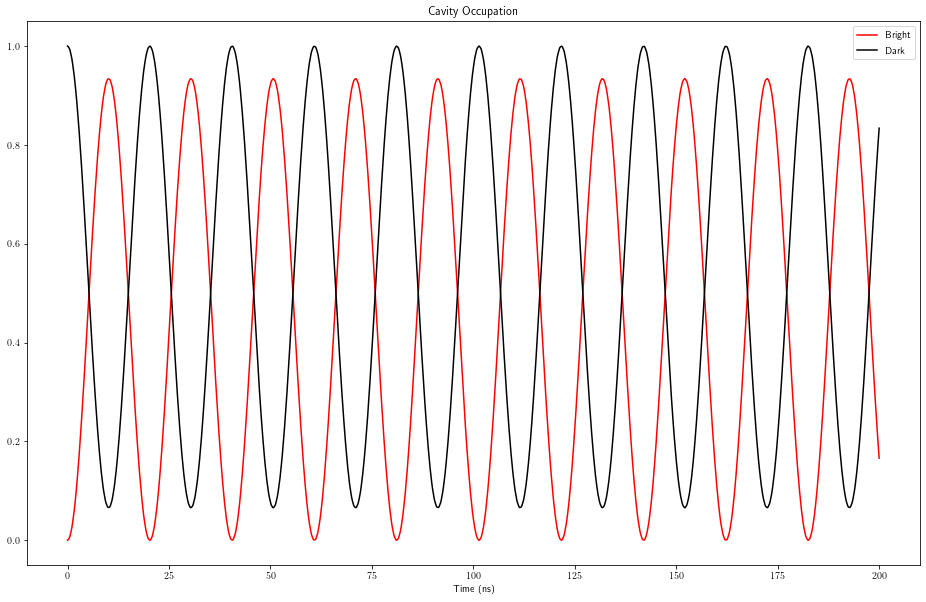

In [153]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(t,rho_cav[:,1,1], label='Bright', color = 'red')
ax.plot(t,rho_cav[:,0,0], label='Dark', color = 'black')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('')
ax.set_title('Cavity Occupation')
plt.legend(loc=0)
plt.show()

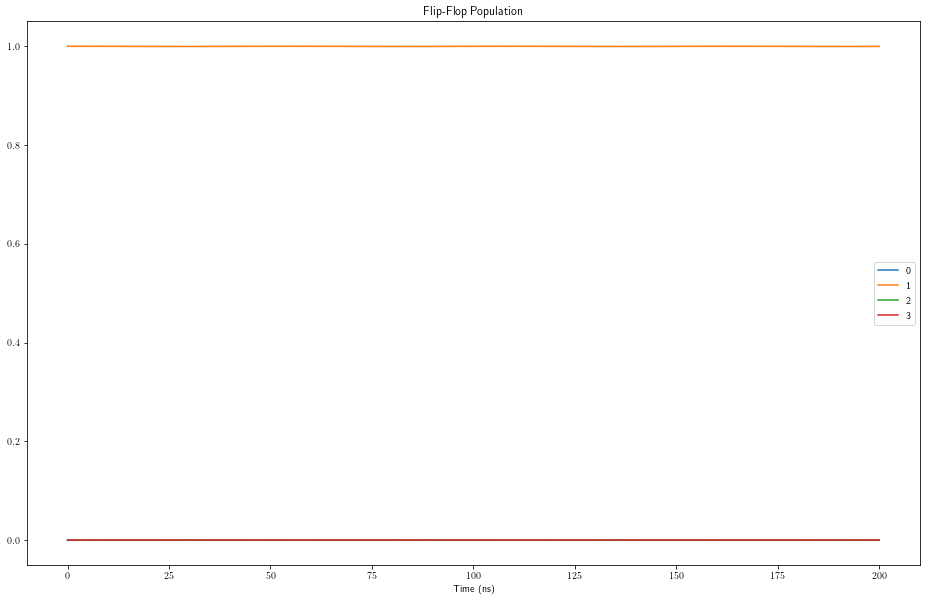

In [148]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(t,rho_ff[:,0,0], label='0')
ax.plot(t,rho_ff[:,1,1], label='1')
ax.plot(t,rho_ff[:,2,2], label='2')
ax.plot(t,rho_ff[:,3,3], label='3')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('')
ax.set_title('Flip-Flop Population')
plt.legend(loc=0)
plt.show()